# Models for ozone 

In this notebook, we develop the models for the transformed dataset considering the exogenous variable to be the **Ozone**.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import tqdm
from utilities import Utilities

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# models 
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression
import statsmodels.api as sm
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor

# others
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures

from scipy.stats import jarque_bera

## Definitions for the notebook

In [4]:
# For local folder
IMAGES_FOLDER = "../notes/images/"
# For Google colab
#IMAGES_FOLDER = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/images/"

# For local folder
location = "../data/"
# For Google colab
#location = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/"

sns.set()

pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

utility = Utilities()

%matplotlib inline

## Importing the dataset

In [5]:
air_data = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p3.csv", index_col = 0)
air_data.weekend = air_data.weekend.astype(int)
air_data = air_data.reset_index().drop(columns="index")
air_data.head()

,year,month,day,CodNum,Lat,Lon,Chuva,Pres,RS,Temp,...,CO_lag24,CO_MA24,O3_lag1,O3_lag2,O3_lag24,O3_MA24,PM10_lag1,PM10_lag2,PM10_lag24,PM10_MA24
0,2011,1,2,1,-22.965,-43.180,3.617,-1.530,-1.128,-0.140,...,-0.763,-0.936,-0.738,-0.543,-1.190,-0.365,0.101,0.078,0.087,0.082
1,2011,1,2,7,-22.898,-43.222,-0.272,-1.513,-0.565,0.560,...,-1.678,-1.232,-0.612,-0.997,-0.724,-0.187,-0.307,-0.967,-1.858,-1.136
2,2011,1,2,3,-22.908,-43.178,3.617,-1.557,-0.720,-0.470,...,-0.634,-0.166,-0.211,-0.717,-0.169,-0.027,-0.677,-0.677,-1.617,-1.141
3,2011,1,2,8,-22.925,-43.233,3.617,-1.909,-0.194,-1.068,...,-0.897,-1.283,-0.267,-0.184,-1.028,0.274,-0.773,-0.583,0.495,-1.061
4,2011,1,2,7,-22.898,-43.222,3.617,-1.658,-0.567,0.548,...,-1.591,-1.206,-1.300,-0.612,-1.099,-0.204,-0.484,-0.307,-0.967,-1.136


## Inverse Power Transformation 

Just for future transformations on ozone data. 

In [6]:
air_data_ = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p2.csv", index_col = 0)

gases = ['CO', 'O3', 'PM10']

pt_gases = {key: PowerTransformer(method = 'yeo-johnson', 
                                  standardize=True).fit(air_data_[[key]]) for key in gases}

del air_data_

## Train and Test

In [7]:
df_train = air_data[air_data.train].drop(columns='train')
df_test = air_data[~air_data.train].drop(columns='train')

x_train = df_train.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])
x_test = df_test.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])

## Tijuca station

The chosen station to report more detailed results.

In [8]:
x_train_SP = x_train[x_train.CodNum == 8].drop(columns="CodNum")
x_test_SP = x_test[x_test.CodNum == 8] .drop(columns="CodNum")

y_train_co = df_train[df_train.CodNum==8].CO
y_test_co = df_test[df_test.CodNum==8].CO

del df_train, df_test

## Linear regression

In [9]:
x_train_SP_sm = sm.add_constant(x_train_SP)
x_test_SP_sm = sm.add_constant(x_test_SP)

reg = sm.OLS(y_train_co, x_train_SP_sm)
resl = reg.fit()
print(resl.summary())

                            OLS Regression Results                            
Dep. Variable:                     CO   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                 1.543e+04
Date:                Tue, 22 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:28:07   Log-Likelihood:                -16819.
No. Observations:               54290   AIC:                         3.369e+04
Df Residuals:                   54263   BIC:                         3.393e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.4573      2.393    -10.222      0.0

In [93]:
y_pred = resl.predict(x_test_SP_sm)

y_train_pred = resl.predict(x_train_SP_sm)

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "simple_linear_regression", {},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8808595273173165
MAE train set: 0.23832367276176322
RMSE train set: 0.3298447000374682
R2 test set: 0.8487335123051067
MAE test set: 0.22323028398014477
RMSE test set: 0.3071856651688438


Let's look at the residuals

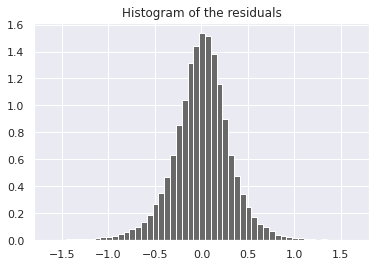

In [11]:
residuals = y_train_pred - y_train_co
plt.hist(residuals, bins = 100, density = True, color = 'dimgray')
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.savefig(IMAGES_FOLDER+"histogram_residuals_co_slr.eps", bbox_inches = 'tight')
plt.show()

In [12]:
print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

Skew: -0.30378439388213696
Kurt: 4.578007534013247
Jarque-Bera: Jarque_beraResult(statistic=48233.04681637398, pvalue=0.0)


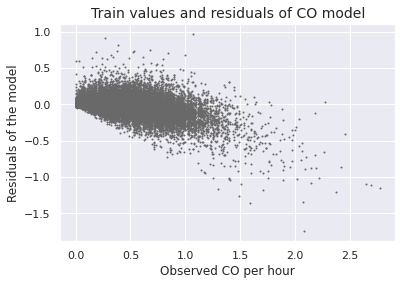

In [14]:
train_trans = pt_gases['CO'].inverse_transform(y_train_co.values.reshape(-1,1))
pred_trans = pt_gases['CO'].inverse_transform(y_train_pred.values.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color='dimgray')
plt.xlabel("Observed CO per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of CO model", fontsize = 14)
plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-co-linear-regression.eps", bbox_inches = 'tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


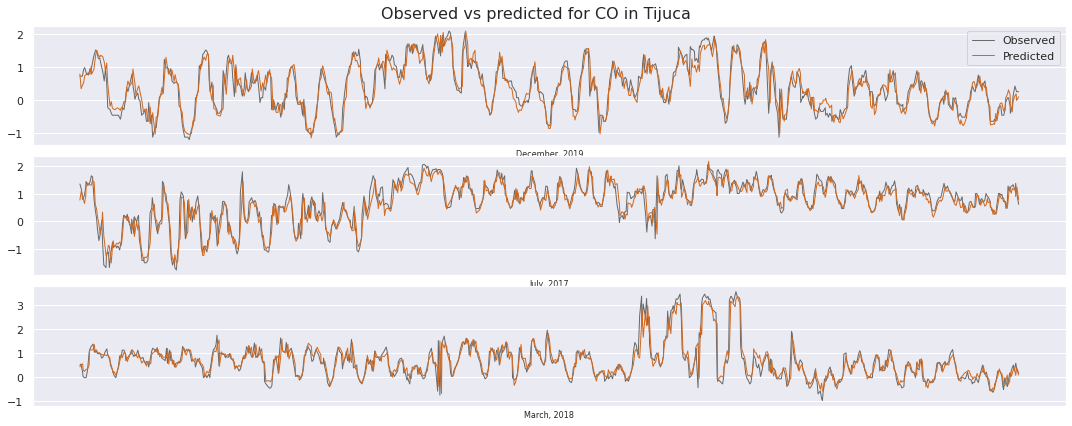

In [20]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_co[rows1.index], linewidth = 1, label = 'Observed', color = 'dimgray')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted', color = 'chocolate')
ax[1].plot(rows2.index, y_test_co[rows2.index], linewidth = 1, color = 'dimgray')
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1, color = 'chocolate')
ax[2].plot(rows3.index, y_test_co[rows3.index], linewidth = 1, color = 'dimgray')
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1, color = 'chocolate')

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for CO in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 8)
ax[1].set_xlabel("July, 2017", fontsize = 8)
ax[2].set_xlabel("March, 2018", fontsize = 8)

ax[0].legend()

plt.savefig(IMAGES_FOLDER+"observed-fitting-co-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

In [22]:
x_train_SP_sm = sm.add_constant(x_train_SP.drop(columns=['O3_lag1','CO_lag1','PM10_lag1',
                                                       'O3_lag2','CO_lag2','PM10_lag2',
                                                        'O3_lag24','CO_lag24','PM10_lag24',
                                                       'O3_MA24','CO_MA24','PM10_MA24']))
x_test_SP_sm = sm.add_constant(x_test_SP.drop(columns=['O3_lag1','CO_lag1','PM10_lag1',
                                                       'O3_lag2','CO_lag2','PM10_lag2', 
                                                       'O3_lag24','CO_lag24','PM10_lag24',
                                                       'O3_MA24','CO_MA24','PM10_MA24']))
test_values = [1,2,4,8,12,24,36,48,60,72,84,108]
r2_test_values = []

for i in test_values:
    
    x_train_SP_sm["CO_lag"] = y_train_co.shift(i)
    x_test_SP_sm["CO_lag"] = y_test_co.shift(i)

    x_train_SP_sm.dropna(inplace=True)
    x_test_SP_sm.dropna(inplace=True)
    y_train_co_ = y_train_co[i:]
    y_test_co_ = y_test_co[i:]

    res = sm.OLS(y_train_co_, x_train_SP_sm).fit()
    y_pred = res.predict(x_test_SP_sm)

    r2_test_values.append(r2_score(y_test_co_, y_pred))

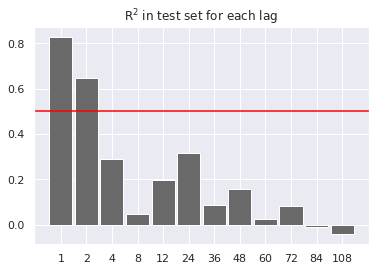

In [23]:
plt.bar([str(i) for i in test_values], r2_test_values, width = 0.9, color = 'dimgray')
plt.axhline(0.5, color = 'red')
plt.title(r"R$^2$ in test set for each lag")
plt.savefig(IMAGES_FOLDER+"r2_test_per_lag_co.eps")
plt.show()

## Elastic-net Regression

For this model, polynomial and interaction terms can be added. This is due to the regularization term.

In [24]:
poly = PolynomialFeatures(2)

x_train_SP_poly = pd.DataFrame(poly.fit_transform(x_train_SP), 
                               columns = poly.get_feature_names(x_train_SP.columns), 
                               index = x_train_SP.index)
x_test_SP_poly = pd.DataFrame(poly.fit_transform(x_test_SP), 
                              columns = poly.get_feature_names(x_test_SP.columns),
                              index = x_test_SP.index)

In [94]:
model = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0],
                     alphas = range(1, 20), 
                     cv = 5, 
                     n_jobs = 2)

model.fit(x_train_SP_poly, y_train_co)

y_pred = model.predict(x_test_SP_poly)

y_train_pred = model.predict(x_train_SP_poly)

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "elastic_net_regression", 
                     {'alpha': float(model.alpha_), 'w_l1': model.l1_ratio_},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8808588744675727
MAE train set: 0.23830652604345712
RMSE train set: 0.3298456037552731
R2 test set: 0.8487604218992246
MAE test set: 0.22309059396152087
RMSE test set: 0.30715834051366564


In [26]:
ind = np.where(model.coef_ != 0)[0]
print(x_train_SP_poly.columns[ind])

Index(['year^2', 'year month', 'year day', 'year Chuva', 'year Pres',
       'year RS', 'year Temp', 'year UR', 'year Dir_Vento', 'year Vel_Vento',
       'year weekend', 'year season', 'year hour_sin', 'year hour_cos',
       'year CO_lag1', 'year CO_lag2', 'year CO_lag24', 'year CO_MA24',
       'year O3_lag1', 'year O3_lag2', 'year O3_lag24', 'year O3_MA24',
       'year PM10_lag1', 'year PM10_lag2', 'year PM10_lag24', 'year PM10_MA24',
       'day^2'],
      dtype='object')


In [27]:
print("Proportion of non zero coefficients: {}".format(ind.shape[0]/model.coef_.shape[0]))

Proportion of non zero coefficients: 0.07142857142857142


In [28]:
residuals = y_train_pred - y_train_co
print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

Skew: -0.30572073949009626
Kurt: 4.580471912725457
Jarque-Bera: Jarque_beraResult(statistic=48294.76968203087, pvalue=0.0)


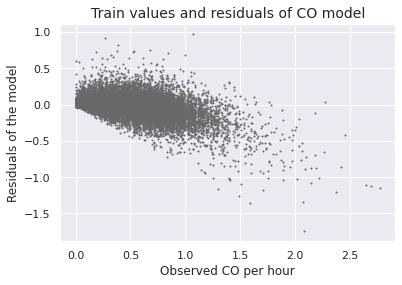

In [29]:
train_trans = pt_gases['CO'].inverse_transform(y_train_co.values.reshape(-1,1))
pred_trans = pt_gases['CO'].inverse_transform(y_train_pred.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'dimgray')
plt.xlabel("Observed CO per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of CO model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

In [30]:
y_pred = pd.Series(y_pred, index = y_test_co.index)

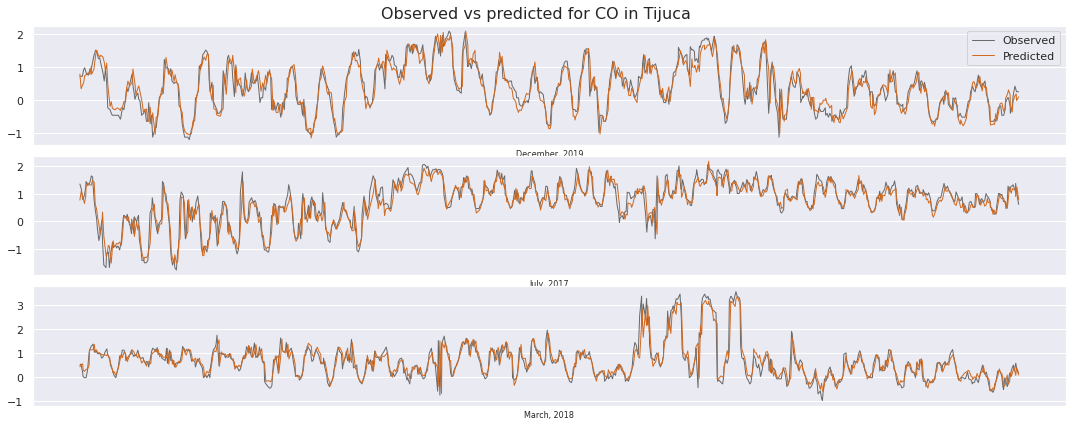

In [31]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_co[rows1.index], linewidth = 1, label = 'Observed', color = 'dimgray')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted', color = 'chocolate')
ax[1].plot(rows2.index, y_test_co[rows2.index], linewidth = 1, color = 'dimgray')
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1, color = 'chocolate')
ax[2].plot(rows3.index, y_test_co[rows3.index], linewidth = 1, color = 'dimgray')
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1, color = 'chocolate')

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for CO in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 8)
ax[1].set_xlabel("July, 2017", fontsize = 8)
ax[2].set_xlabel("March, 2018", fontsize = 8)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

## Feature Selection + Linear regression

The Forward Feature Selection is performed with polynomial and interaction terms.

In [33]:
regr = LinearRegression()

best_features = utility.forward_selection(data = x_train_SP_poly, 
                                          target = y_train_co,
                                          regr = regr, 
                                          k_fold = 5, 
                                          threshold = 0.001
                                         )

In [34]:
print(best_features)

['CO_lag1', 'hour_sin^2', 'CO_lag24', 'hour_cos', 'year Vel_Vento', 'CO_MA24', 'RS PM10_lag1', 'CO_lag2', 'Vel_Vento^2']


In [95]:
x_train_SP_sm = sm.add_constant(x_train_SP_poly[best_features])
x_test_SP_sm = sm.add_constant(x_test_SP_poly[best_features])

reg = sm.OLS(y_train_co, x_train_SP_sm)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CO   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 4.589e+04
Date:                seg, 21 jun 2021   Prob (F-statistic):               0.00
Time:                        17:13:40   Log-Likelihood:                -16131.
No. Observations:               54290   AIC:                         3.228e+04
Df Residuals:                   54280   BIC:                         3.237e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1558      0.003    -53.

In [96]:
y_pred = res.predict(x_test_SP_sm)

y_train_pred = res.predict(x_train_SP_sm)

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "ffs_linear_regression", 
                     {'threshold': 0.001, 'best_features': best_features},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8838436346301088
MAE train set: 0.23504345242869282
RMSE train set: 0.32568770049773504
R2 test set: 0.851924531869582
MAE test set: 0.22018020604222935
RMSE test set: 0.3039283001630054


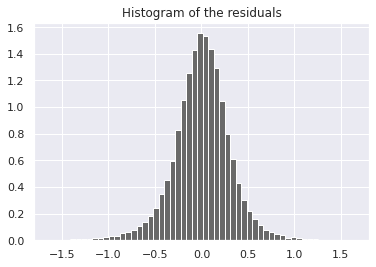

Skew: -0.2969241557315723
Kurt: 4.776860825884944
Jarque-Bera: Jarque_beraResult(statistic=52402.91850483306, pvalue=0.0)


In [37]:
residuals = y_train_pred - y_train_co
plt.hist(residuals, bins = 100, density = True, color = 'dimgray')
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.show()

print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

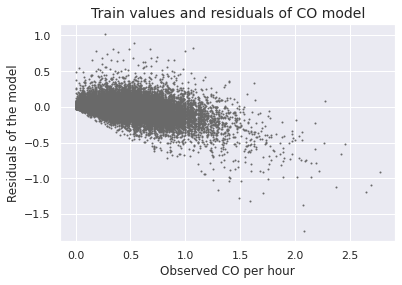

In [38]:
train_trans = pt_gases['CO'].inverse_transform(y_train_co.values.reshape(-1,1))
pred_trans = pt_gases['CO'].inverse_transform(y_train_pred.values.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'dimgray')
plt.xlabel("Observed CO per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of CO model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

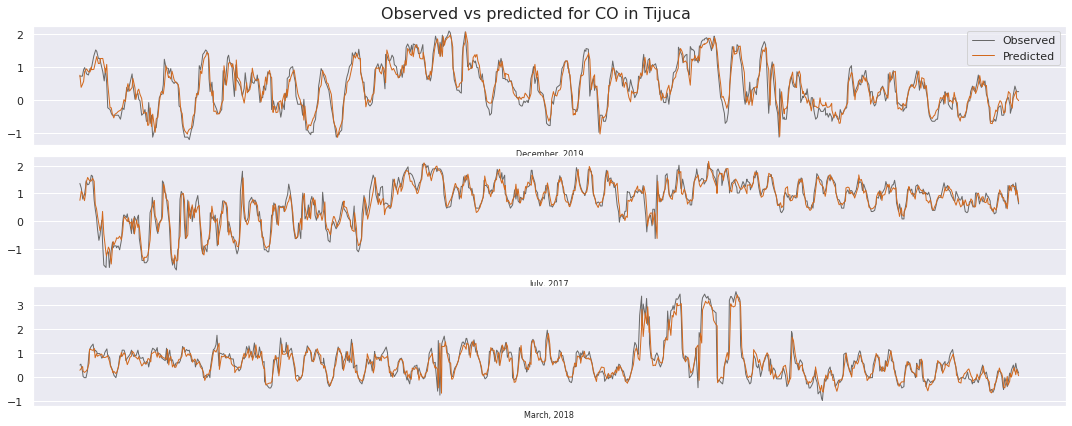

In [39]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_co[rows1.index], linewidth = 1, label = 'Observed', color='dimgray')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted', color='chocolate')
ax[1].plot(rows2.index, y_test_co[rows2.index], linewidth = 1, color='dimgray')
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1, color='chocolate')
ax[2].plot(rows3.index, y_test_co[rows3.index], linewidth = 1, color='dimgray')
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1, color = 'chocolate')

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for CO in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 8)
ax[1].set_xlabel("July, 2017", fontsize = 8)
ax[2].set_xlabel("March, 2018", fontsize = 8)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

## Support vector machine

Considering the SVR with linear kernel. We make a grid search with cross-validation to estimate the best values from these above. 

In [40]:
scaler = StandardScaler()
svr = LinearSVR(epsilon = 0.1, 
                C = 1/2,
                max_iter = 2000)

pipe = Pipeline(steps=[('scaler', scaler), 
                       ('svr', svr)])

param_grid = {
    'svr__epsilon': [0.001, 0.01, 0.1, 0.2, 0.3],
    'svr__C': np.logspace(-3,2,6)
}

search = GridSearchCV(estimator = pipe, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error',
                      cv = 5, 
                      verbose = 4, 
                      n_jobs=-1)

search.fit(x_train_SP, y_train_co)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameter (CV score=-0.111):
{'svr__C': 0.01, 'svr__epsilon': 0.2}


After the grid search with cross validation, the best parameters are used for the non linear kernel SRF to compare the waiting time.

In [41]:
epsilon = search.best_params_['svr__epsilon']
C = search.best_params_['svr__C']

In [97]:
%%time
svr = make_pipeline(StandardScaler(), 
                    SVR(kernel = 'rbf', 
                        degree = 2, 
                        epsilon = epsilon, 
                        C = C,
                        max_iter = 200000))

svr.fit(x_train_SP, y_train_co)

CPU times: user 1min 17s, sys: 54.9 ms, total: 1min 17s
Wall time: 1min 17s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, epsilon=0.2, max_iter=200000))])

In [98]:
y_pred = svr.predict(x_test_SP)

y_train_pred = svr.predict(x_train_SP)

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "svr_rbf", 
                     {'epsilon': epsilon, 'C': C, 'degree': 2},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8686809134137647
MAE train set: 0.25325847962626474
RMSE train set: 0.3462930515598881
R2 test set: 0.7674303439232302
MAE test set: 0.28381153557254185
RMSE test set: 0.38089573458008097


With the linear kernel.

In [99]:
%%time
svr = make_pipeline(StandardScaler(), 
                    LinearSVR(epsilon = epsilon, 
                              C = C,
                              max_iter = 10000))

svr.fit(x_train_SP, y_train_co)

CPU times: user 347 ms, sys: 12 ms, total: 359 ms
Wall time: 360 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(C=0.01, epsilon=0.2, max_iter=10000))])

In [100]:
y_pred = svr.predict(x_test_SP)

y_train_pred = svr.predict(x_train_SP)

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "svr_linear", 
                     {'epsilon': epsilon, 'C': C},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.880389381257047
MAE train set: 0.2367115150608468
RMSE train set: 0.3304948674255918
R2 test set: 0.8478858509631387
MAE test set: 0.22270790770780743
RMSE test set: 0.30804516037367635


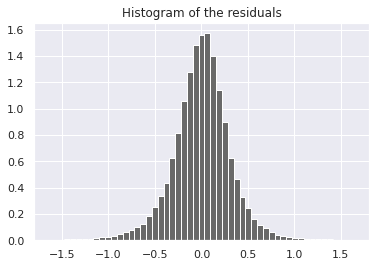

Skew: -0.3145124694363417
Kurt: 4.890516849680342
Jarque-Bera: Jarque_beraResult(statistic=54985.18253254398, pvalue=0.0)


In [46]:
residuals = y_train_pred - y_train_co
plt.hist(residuals, bins = 100, density = True, color = 'dimgray')
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.show()

print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

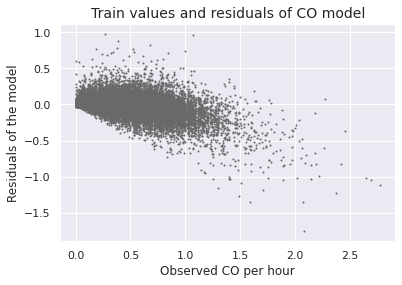

In [47]:
train_trans = pt_gases['CO'].inverse_transform(y_train_co.values.reshape(-1,1))
pred_trans = pt_gases['CO'].inverse_transform(y_train_pred.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'dimgray')
plt.xlabel("Observed CO per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of CO model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

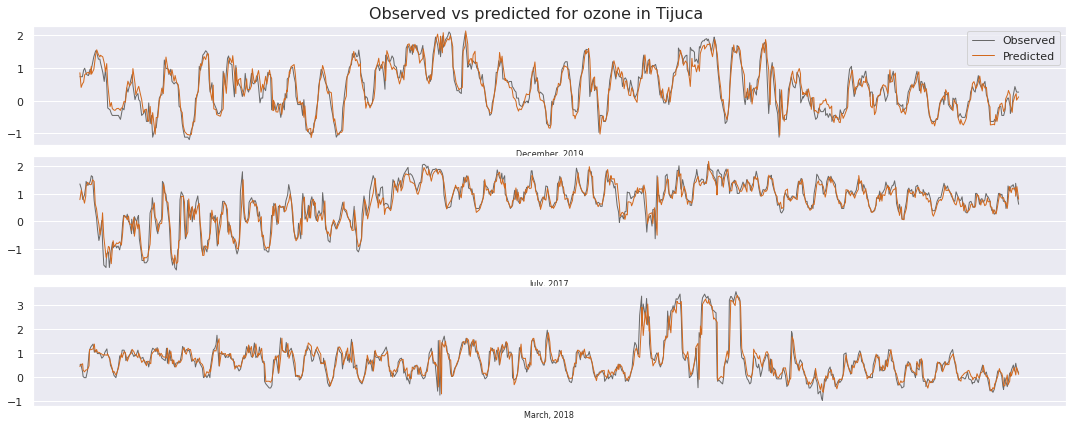

In [48]:
y_pred = pd.Series(y_pred, index = y_test_co.index)

rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_co[rows1.index], linewidth = 1, label = 'Observed', color = 'dimgray')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted', color = 'chocolate')
ax[1].plot(rows2.index, y_test_co[rows2.index], linewidth = 1, color = 'dimgray')
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1, color = 'chocolate')
ax[2].plot(rows3.index, y_test_co[rows3.index], linewidth = 1, color = 'dimgray')
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1, color = 'chocolate')

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for CO in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 8)
ax[1].set_xlabel("July, 2017", fontsize = 8)
ax[2].set_xlabel("March, 2018", fontsize = 8)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

Considering the best features selected by Linear Regression. 

In [49]:
best_features = ['CO_lag1', 'hour_sin^2', 'CO_lag24', 'hour_cos', 'year Vel_Vento', 
                 'CO_MA24', 'RS PM10_lag1', 'CO_lag2', 'Vel_Vento^2']

In [101]:
%%time
svr = make_pipeline(StandardScaler(), 
                    LinearSVR(epsilon = epsilon, 
                              C = C,
                              max_iter = 10000))

svr.fit(x_train_SP_poly[best_features], y_train_co)

CPU times: user 146 ms, sys: 3.95 ms, total: 150 ms
Wall time: 150 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(C=0.01, epsilon=0.2, max_iter=10000))])

In [102]:
y_pred = svr.predict(x_test_SP_poly[best_features])

y_train_pred = svr.predict(x_train_SP_poly[best_features])

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "svr_linear_best_features", 
                     {'epsilon': epsilon, 'C': C},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8833761041202708
MAE train set: 0.2332367691505759
RMSE train set: 0.326342490369865
R2 test set: 0.8515741777172392
MAE test set: 0.21846253331013152
RMSE test set: 0.30428764270615277


In [103]:
%%time
svr = make_pipeline(StandardScaler(), 
                    SVR(kernel = 'rbf', 
                        degree = 2, 
                        epsilon = epsilon, 
                        C = C,
                        max_iter = 200000))

svr.fit(x_train_SP_poly[best_features], y_train_co)

CPU times: user 1min 4s, sys: 83.1 ms, total: 1min 4s
Wall time: 1min 4s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, epsilon=0.2, max_iter=200000))])

In [104]:
y_pred = svr.predict(x_test_SP_poly[best_features])

y_train_pred = svr.predict(x_train_SP_poly[best_features])

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "svr_rbf_best_features", 
                     {'epsilon': epsilon, 'C': C},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.876779714746886
MAE train set: 0.24263335510341433
RMSE train set: 0.3354447164349643
R2 test set: 0.838043609707939
MAE test set: 0.22464515058780746
RMSE test set: 0.31785469318888804


## Random Forest

In [54]:
scaler = StandardScaler()
rand_forest = RandomForestRegressor(n_estimators = 100, 
                                    criterion = 'mse', 
                                    min_samples_split = 10, 
                                    max_features = 'sqrt',
                                    ccp_alpha = 0.0,
                                    n_jobs=2,
                                    )

pipe = Pipeline(steps=[('scaler', scaler), 
                       ('forest', rand_forest)])

param_grid = {
    'forest__min_samples_split': [10, 20, 50, 100],
    'forest__ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 1]
}

search = GridSearchCV(estimator = pipe, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error',
                      cv = 5, 
                      verbose = 4, 
                      n_jobs=2)

search.fit(x_train_SP, y_train_co)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameter (CV score=-0.124):
{'forest__ccp_alpha': 0.0, 'forest__min_samples_split': 20}


In [107]:
B = 100
c = search.best_params_['forest__ccp_alpha']
s = search.best_params_['forest__min_samples_split']

In [108]:
rand_forest = RandomForestRegressor(n_estimators = 500, 
                                    criterion = 'mse', 
                                    min_samples_split = s, 
                                    max_features = 'sqrt',
                                    ccp_alpha = c,
                                    n_jobs = 2,
                                    )
rand_forest.fit(x_train_SP, y_train_co)

RandomForestRegressor(max_features='sqrt', min_samples_split=20,
                      n_estimators=500, n_jobs=2)

In [109]:
y_pred = rand_forest.predict(x_test_SP)

y_train_pred = rand_forest.predict(x_train_SP)

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "random_forest", 
                     {'s': s, 'c': c, 'B': 100},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.9482291169174952
MAE train set: 0.157466684341468
RMSE train set: 0.21743158780111604
R2 test set: 0.8478384741451302
MAE test set: 0.22107720896221356
RMSE test set: 0.30809312784879


Changing the grid a little. 

In [58]:
rand_forest = RandomForestRegressor(n_estimators = 100, 
                                    criterion = 'mse', 
                                    min_samples_split = 10, 
                                    max_features = 'sqrt',
                                    ccp_alpha = 0.0,
                                    n_jobs=2,
                                    verbose=4,
                                    )

pipe = Pipeline(steps=[('scaler', scaler), 
                       ('forest', rand_forest)])

param_grid = {
    'forest__min_samples_split': [2, 5, 8],
    'forest__ccp_alpha': [0.0, 0.01, 1.]
}

search = GridSearchCV(estimator = pipe, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error',
                      cv = 5, 
                      verbose = 4, 
                      n_jobs=2)

search.fit(x_train_SP, y_train_co)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    2.2s


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65

[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:    9.7s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Best parameter (CV score=-0.123):
{'forest__ccp_alpha': 0.0, 'forest__min_samples_split': 5}


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.3s finished


In [110]:
B = 100
c = search.best_params_['forest__ccp_alpha']
s = search.best_params_['forest__min_samples_split']

In [111]:
rand_forest = RandomForestRegressor(n_estimators = 500, 
                                    criterion = 'mse', 
                                    min_samples_split = s, 
                                    max_features = 'sqrt',
                                    ccp_alpha = c,
                                    n_jobs = 2,
                                    )
rand_forest.fit(x_train_SP, y_train_co)

RandomForestRegressor(max_features='sqrt', min_samples_split=5,
                      n_estimators=500, n_jobs=2)

In [112]:
y_pred = rand_forest.predict(x_test_SP)

y_train_pred = rand_forest.predict(x_train_SP)

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "random_forest", 
                     {'s': s, 'c': c, 'B': 100},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.9792374471537466
MAE train set: 0.09656303895587005
RMSE train set: 0.13769565181798885
R2 test set: 0.8480918560301808
MAE test set: 0.22100190908972903
RMSE test set: 0.30783650008751473


In [113]:
rand_forest = RandomForestRegressor(n_estimators = 500, 
                                    criterion = 'mse', 
                                    min_samples_split = 5, 
                                    max_features = 'sqrt',
                                    ccp_alpha = 0.0,
                                    n_jobs = 2,
                                    )
rand_forest.fit(x_train_SP_poly[best_features], y_train_co)

RandomForestRegressor(max_features='sqrt', min_samples_split=5,
                      n_estimators=500, n_jobs=2)

In [114]:
y_pred = rand_forest.predict(x_test_SP_poly[best_features])

y_train_pred = rand_forest.predict(x_train_SP_poly[best_features])

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "random_forest_best_features", 
                     {'s': 5, 'c': 0, 'B': 500},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.9746820895117388
MAE train set: 0.10739316632951068
RMSE train set: 0.15205257554374377
R2 test set: 0.8520790020461836
MAE test set: 0.21784333634029143
RMSE test set: 0.3037697320051104


## Linear Regression + Expectation Maximization

For this model, we asked for help from `R`. 

In [10]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector, r

norm = importr("norm")

Training the model with normal variables

In [11]:
df_train = utility.linear_regression_em_preparation(location, gas_name='CO')

In [12]:
X_r = FloatVector(df_train.values.flatten())
m = r['matrix'](X_r, ncol = df_train.shape[1], byrow = True)

s = norm.prelim_norm(m)  
theta = norm.em_norm(s)
params = norm.getparam_norm(s,theta,corr=False)
params = dict(zip(params.names, map(np.array,list(params))))

Iterations of EM: 
1...2...3...4...5...6...7...8...


In [13]:
mu_y = params['mu'][-1]
mu_X = params['mu'][:-1].reshape(-1,1)

Sigma_XX = params['sigma'][:-1,:-1]
Sigma_yX = params['sigma'][-1,:-1].reshape(1,-1)
Sigma_Xy = params['sigma'][:-1,-1].reshape(-1,1)
Sigma_yy = params['sigma'][-1,-1]

inv_Sigma_XX = np.linalg.inv(Sigma_XX)

beta = np.hstack([mu_y - Sigma_yX@inv_Sigma_XX@mu_X, Sigma_yX@inv_Sigma_XX]).reshape(-1,1)

In [14]:
diff_regression = pd.DataFrame({'linear-regression': resl.params.values, 
                                'linear-regression-em': beta.flatten(), 
                                'ratio': resl.params.values/beta.flatten()},
                                 index = resl.params.index)

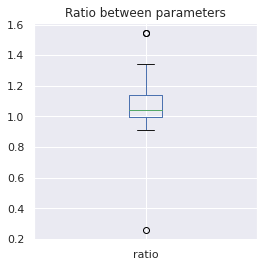

In [15]:
diff_regression.ratio.plot.box(figsize = (4,4), title = 'Ratio between parameters');
plt.savefig(IMAGES_FOLDER+'boxplot_ratio_co_linear_regression.eps', bbox_inches = 'tight')

In [117]:
y_pred = x_test_SP@beta[1:] + beta[0]

y_train_pred = x_train_SP@beta[1:] + beta[0]

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "linear_regression_em", 
                     {},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8807244137903747
MAE train set: 0.2383235652256958
RMSE train set: 0.33003168037905367
R2 test set: 0.8491176144365737
MAE test set: 0.2225379455049376
RMSE test set: 0.30679540798930266


In [84]:
df_train_2 = pd.DataFrame()

for feat in best_features: 
    feats = feat.split()
    if len(feats) == 2: 
        df_train_2[feat] = df_train[feats[0]]*df_train[feats[1]]
    elif feats[0][-2] == '^': 
        df_train_2[feat] = df_train[feats[0][:-2]]**2
    else: 
        df_train_2[feat] = df_train[feats[0]]
        
df_train_2['CO'] = df_train['CO']

In [118]:
X_r = FloatVector(df_train_2.values.flatten())
m = r['matrix'](X_r, ncol = df_train_2.shape[1], byrow = True)

s = norm.prelim_norm(m)  
theta = norm.em_norm(s)
params = norm.getparam_norm(s,theta,corr=False)
params = dict(zip(params.names, map(np.array,list(params))))

Iterations of EM: 
1...2...3...4...5...6...


In [119]:
mu_y = params['mu'][-1]
mu_X = params['mu'][:-1].reshape(-1,1)

Sigma_XX = params['sigma'][:-1,:-1]
Sigma_yX = params['sigma'][-1,:-1].reshape(1,-1)
Sigma_Xy = params['sigma'][:-1,-1].reshape(-1,1)
Sigma_yy = params['sigma'][-1,-1]

inv_Sigma_XX = np.linalg.inv(Sigma_XX)

beta = np.hstack([mu_y - Sigma_yX@inv_Sigma_XX@mu_X, Sigma_yX@inv_Sigma_XX]).reshape(-1,1)

In [120]:
y_pred = x_test_SP_poly[best_features]@beta[1:] + beta[0]

y_train_pred = x_train_SP_poly[best_features]@beta[1:] + beta[0]

r2_train = r2_score(y_train_co, y_train_pred)
r2_test  = r2_score(y_test_co, y_pred)
mae_train = mean_absolute_error(y_train_co, y_train_pred)
mae_test  = mean_absolute_error(y_test_co, y_pred)
rmse_train = mean_squared_error(y_train_co, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_co, y_pred, squared = False)

utility.save_metrics("CO", 8, "linear_regression_em_best_features", 
                     {},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8837626882136518
MAE train set: 0.23464993643005327
RMSE train set: 0.3258011624711069
R2 test set: 0.8517144073010128
MAE test set: 0.21998629044934945
RMSE test set: 0.3041438664681273


## Model comparison

In [121]:
import json 

with open('../data/models.json', 'r') as f: 
    models = json.load(f)
    models_co = {key: value for (key,value) in models.items() if value['gas'] == 'CO' and value['station'] == 8}

In [122]:
df_models = pd.DataFrame()
for i in models_co.keys():
    df_models = df_models.append(pd.json_normalize(models_co[i]), ignore_index = True)

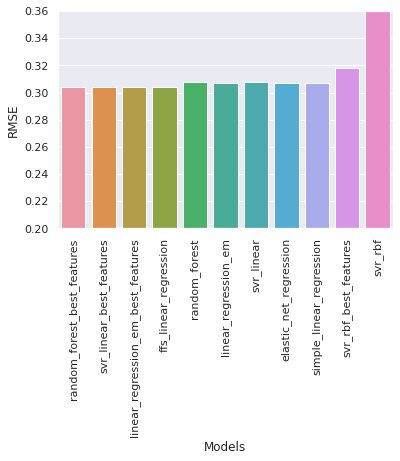

In [125]:
df_models = df_models.sort_values(by = 'mae_test')
sns.barplot(x = 'model_name', y = 'rmse_test', data = df_models)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
plt.ylim(0.2,0.36)
plt.xlabel('Models');
plt.savefig(IMAGES_FOLDER+'model-comparison-co-tijuca.eps', bbox_inches = 'tight')